In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly
import pyclipper

# Project 4 - Motion Planning

### Introduction to Trajectory Optimization
- Introduce dynamics equations As + Bu = z
- Single obstacle encoding as constraints
    - Demonstrate creating a convex polygon bound
    - Show constraint formulation for OR constraints using big M notation
- Speed limit
    - Quadratic constraint on s'

## Simple Robot Path Planning - Single Obstacle

We'll start by considering a simplified version of our ultimate problem, and examine constraint-based path planning throgh a single-obstacle environment to reach a single goal. In an 8x8 unit environment, we define our problem conditions as follows:

- Robot Start Point: `(1,1)`
- Goal Region: Rectangle region bounded by `[(6,6), (6,7), (7,7), (7, 6)]`
- Obstacles: Single obstacle bounded by `[(3,2), (2,5), (6,3)]`

Our goal will be to minimize distance traveled.

Run the code in the next cell to preview the starting environment.



(5.5, 5.5)


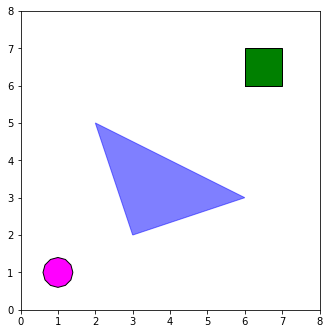

In [2]:
# Sample Problem
obstacles = [(3,2), (2,5), (6,3)]
start = (1,1)
goal = [(6,6), (6,7), (7,7), (7, 6)]

env = Environment(None)
env.add_obstacles([Polygon(obstacles)])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.4, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

In order to simplify the problem, we would like to treat our robot as a point object. To do this, we add a buffer, equal to the robot's radius, to every obstacle in the environment. This allows us to consider the robot as a point, rather than a moving area, and still take into account the robot's size to avoid collision with obstacles. 

To make this easy, we'll use the `pyclipper` package to create the buffer. The example code below performs this task for our example environment and obstacle:

(5.5, 5.5)
Buffered Obstacles: 
 [[[6.521310369484127, 2.9629516126587987], [1.6575750685296953, 5.394819263368845], [2.8735088938847184, 1.7470177877694368]]]


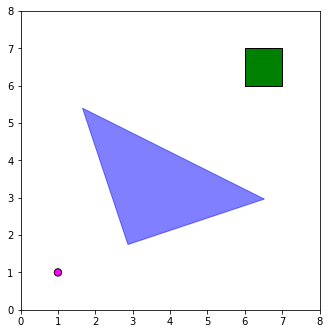

In [3]:
# Redefine obstacles with radius of droid; treat droid as a point robot
obs = (obstacles)
pco = pyclipper.PyclipperOffset()
pco.MiterLimit = 10
pco.AddPath(pyclipper.scale_to_clipper(obs), pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
buff_obs = pyclipper.scale_from_clipper(pco.Execute(pyclipper.scale_to_clipper(.2)))

env = Environment(None)
env.add_obstacles([Polygon(buff_obs[0])])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.1, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, goal_region,'green')

print('Buffered Obstacles: \n', buff_obs)

**Dynamics equations:** 

In this part, we will incorporate robot dynamics, time (arrival) constraints. The initial location, goal locations, the geometry of factory and obstacles, and vehicle speed limits are the inputs. In this case, we assume that the robots always move at the top speed to meet the time constraints. And the effect of acceleration is ignored, which means that the robot can always move at the desired velocity at a given time. And all the physical parameters of the robots are the same. 

Under these assumptions, the only dynamic equation can be written as:

$$ s = u*t $$

where s is the distance the robot can travel; u is the max velocity; and t is the time duration. And it can be translated into the matrix form:

$$  \begin{pmatrix}x_{i+1}\\y_{i+1}\\\dot{x}_{i+1}\\\dot{y}_{i+1}\end{pmatrix} = \begin{pmatrix}1&0& \bigtriangleup t &0\\0&1&0&\bigtriangleup t\\0&0&1&0\\0&0&0&1\end{pmatrix}  \begin{pmatrix}x_{i}\\y_{i}\\\dot{x}_{i}\\\dot{y}_{i}\end{pmatrix}$$


### Obstacle encoding as constraints

Since all the obstacles in this problem are stationary, we can easily encode arbitrarily shaped obstacles using constraints. And exactly 1 of them must be applied. And the concave shape can be dealt with by chopping them into multiple convex objects, or by setting a convex boundary that encompasses the entire shape.

For example, if the obstacle is a square shaped by $[x_{min}, x_{max}]$ and $[y_{min}, y_{max}]$. The obstacle can be expressed by: 

$$  \forall i  \in [1,2,3,...,]:$$
$$ x_i \leq x_{min}$$
or $$ x_i \geq x_{max}$$
or $$ y_i \leq y_{min}$$
or $$  y_i \geq y_{max}$$

And for the workstations in this task formed by straight lines, the constraints can be expressed with the line function for each edge.

#### Next we must reformulate these constraints to get rid of the "OR" statements, as this would make the program non-linear

Carrying forward the example of the square shaped by $[x_{min}, x_{max}]$ and $[y_{min}, y_{max}]$, we introduce the notion of the binary variable $t_{i,k}$ where $i \in [1,2,3,...L]$, $L$ is the number of obstacles, and $k$ is the index of each side of the square such that $k \in [1,2,3,4]$. The binary variable $t_{i,k}$ is known as a _slack_ variable. A _slack_ variable allows us to transform and inequality into an equality, or in this case, an "or" statement into an "and" statement. For example, take the following inequality:
\begin{equation}
\bf{A}x \leq b
\end{equation}
We introduce the slack variable $y \geq 0$ which allows us to transform the above inequality into the following equality:
\begin{equation}
\bf{A}x + y = b
\end{equation}
Because $y$ can compensate for the "slack" between b and $\bf{A}x$ and make it so that $\bf{A}x + y$ is always equal to $b$.

Therefore, to transform the "or" statements from the section above into "and" statements, we use $t_{i,k}$ together with an arbitrarily large positive number $M$. 
$$\forall i \in [1,2,...,N] \quad x_i \leq x_{min} + M t_{i1}$$
and$$            \quad     -x_i \geq -x_{max} + M t_{i2}$$
and$$            \quad       y_i \leq y_{min} + M t_{i3}$$
and$$            \quad      -y_i \geq -y_{max} + M t_{i4}$$
and$$            \quad \Sigma_{k=1}^{4} t_{i,k} \leq 3$$
For example, $t_{i1}=0$ if $x_i \leq x_{min}$. If $x_i \gt x_{min}$, then $t_{i1}=1$ and since $M$ is a large positive number, we satisfy the constraint that $x_i \leq x_{min} + M t_{i1}$. In order to classify a position $(x_i,y_i)$ as within obstacle $i$, $\Sigma_{k=1}^{4} t_{i,k} = 4$ which has the same meaning as all of the "or" statements in the previous section being false.

#### Next we must reformulate these constraints so that they can apply to an obstacle shaped as a n-sided polygon
The extension of the constraint enumeration to an obstacle shaped as a n-sided polygon is fairly trivial; the number of per-obstacle constraint equations is always $n+1$ with the last constraint equation resembling:
$$\Sigma_{k=1}^{n} t_{i,k} \leq n-1$$
The challenge in extending the obstacle encoding problem to obstacles shaped as n-sided polygons is the fact that an edge of the obstacle could _not_ be orthogonal to either the environment's X or Y axes. 

To begin, each polygon will have $n$ sides. We will denote each side with a pair of coordinates that correspond to the two vertexes that define the edges of the side; therefore, side $n_k = \{(x_{i,k},y_{i,k}),(x_{i,k'},y_{i,k'})\}$ such that $k \in [1,2,..L], k \neq k'$. From here, we can define a line segment for each side of the polygon
$$y_{i,k} = A_{i,k} x_{i,k} + b_{i,k}$$
Where $A_{i,k}$ is the slope of each side $l$. We can calculate $A_{i,k}$ by
$$A_{i,k} = \frac{y_{i,k'}-y_{i,k}}{x_{i,k'}-x_{i,k}}\quad s.t.\quad x_{i,k'}-x_{i,k} \neq 0\quad and \quad y_{i,k'}-y_{i,k} \neq 0$$
and calculate $b_{i,k}$ by substituting a point along the side for the values $(x_{i,k},y_{i,k})$ and solving for $b_{i,k}$. If $x_{i,k'}-x_{i,k} \eq 0$ or $y_{i,k'}-y_{i,k} \eq 0$, the side is parallel to the y-axis and x-axis, respectively. In these cases, the constraint equation for the side follows from the previous section. All sides that are not orthogonal to an axis can be represented by the following constraint equation:
$$y_i \leq A_{i,k}x_i + b_{i,k} + M t_{i,k}$$
Where $t_{i,k}$ and $M$ carry forward from the previous section. Therefore, the full set of constraint equations for sides of a square whose sides are not orthogonal to either the x-axis or y-axis can be described by the following:
$$\forall i \in [1,2,...,N] \quad y_i \leq A_{i,1}x_{i} + b_{i,1} + M t_{i1}$$
and$$            \quad     -y_i \geq -(A_{i,2}x_{i} + b_{i,2}) + M t_{i2}$$
and$$            \quad       y_i \leq A_{i,3}x_{i} + b_{i,3} + M t_{i3}$$
and$$            \quad      -y_i \geq -(A_{i,4}x_{i} + b_{i,4}) + M t_{i4}$$
and$$            \quad \Sigma_{k=1}^{4} t_{i,k} \leq 3$$

#### Example

The code block below shows a polygon with sides that are orthogonal to the x-axis and y-axis as well as sides that are not orthogonal. Feel free to change the points in order to see whether they fall inside or outside of the polygon.


(5.5, 5.5)
Point 1 is NOT in obstacle 1
Point 2 IS in obstacle 1


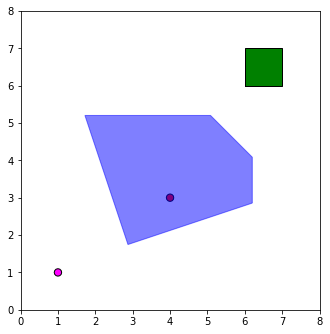

In [22]:
# Change obstacle points and start point at will
obs = ([(3,2), (2,5), (5,5),(6,4),(6,3)])
start = (1,1)
other = (4,3)

# DO NOT Change Below Here
pco = pyclipper.PyclipperOffset()
pco.MiterLimit = 10
pco.AddPath(pyclipper.scale_to_clipper(obs), pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
buff_obs = pyclipper.scale_from_clipper(pco.Execute(pyclipper.scale_to_clipper(.2)))

env = Environment(None)
env.add_obstacles([Polygon(buff_obs[0])])
bounds = (0, 0, 8, 8)
ax = plot_environment(env, bounds=bounds)
start_point = Point(start).buffer(0.1, resolution=3)
other_point = Point(other).buffer(0.1, resolution=3)
goal_region = Polygon(goal)
plot_poly(ax, start_point,'magenta')
plot_poly(ax, other_point,'red')
plot_poly(ax, goal_region,'green')
points = (start, other)
numObs = len(env.obstacles)
for p in range(0,len(points)):
    point = points[p]
    for i in range(0,numObs):
        obstacle = env.obstacles[i]
        vertexes = list(obstacle.exterior.coords)
        numSides = len(vertexes)-1
        t = []
        x_center = 0
        y_center = 0
        for vertex in range(0,numSides):
            x_center = x_center + vertexes[vertex][0]
            y_center = y_center + vertexes[vertex][1]
        x_center = x_center/numSides
        y_center = y_center/numSides
        for vertex in range(0,numSides):
            x = vertexes[vertex][0]
            y = vertexes[vertex][1]
            num = vertexes[vertex+1][1] - vertexes[vertex][1]
            den = vertexes[vertex+1][0] - vertexes[vertex][0]
            if(den == 0):
                if(x_center < x):
                    t.append(point[0]<x)
                elif(x_center > x):
                    t.append(point[0]>x)
            else:
                A = (num/den)
                b = y-A*x
                if(y_center < A*x_center + b):
                    t.append(point[1] < A*point[0]+b)
                elif(y_center > A*x_center + b):
                    t.append(point[1] > A*point[0]+b)
        if(False not in t):
            print('Point %d IS in obstacle %d'%(p+1,i+1))
        else:
            print('Point %d is NOT in obstacle %d'%(p+1,i+1))
#should print out True, True, True, False, False. Goes around sides counterclockwise starting at vertical line.


**The speed limit**

The speed limit in this case is provided by the problem for each robot. And we assume that the robots move at the max allowed speed provided. 

### Space Station Problem Introduction
- Go through same steps as above
- Introduce multi-vehicle problem
    - Collision avoidance
    - Each waypoint visited by only one vehicle

In the real space station problem, it is a little different from the simplified problem above. The number of robots is bigger than 1, which means that we need to add dynamic equations and constrait equations for each robot. One of the big change here is the non-collision constraint, which can be formalized by that all the robot pairs keep a minimum distance accoding their own coordination. But the process to solve the problem is relatively similar as the one we use in the simplified problem.

### Encoding of Problem - MIQCP

Since the speed limit is given, the distance traveled in a given time step is a quadratic constraint. 

Thus the whole problem can be encoded as a motion planning problem based on MIQCP with the constriant of speed limitation, time limitation (termination constraint), non-collision constraint, obstacle constraint with the objective function of time to finish the whole task. 

## Outstanding Questions
- What is the data structure we will be using for obstacles, paths, etc? Similar to HW6?
- Are workstations that are not the current goal to be treated as obstacles?
- Objective function = minimize time?
- Multiple droids? These must avoid eachother while moving, right? How many?
- Are we ignoring acceleration, and only considering velocity? So robots are stopped or traveling at max speed at all times?
- Which solver are we using?
